## Overview of approach

In this study, a novel data sampling approach was employed to ensure representative segmentation. The strategy focused on maximizing diversity among clusters to accurately capture the essence of the original dataset. The data was partitioned into 10,000 clusters, mirroring the sample dataset's size. To enhance diversity, the data point closest to each cluster's centroid was selected and added to the sample dataset, thus promoting a diverse representation.

The reliability of the sample dataset was validated through comprehensive data analysis, demonstrating similarities in insights between the sample and actual data.

As part of our modelling pipeline, the adopted approach is two folds:

**Creation of Gold Standard Data**: Various Large language models (LLMs) were employed to generate gold standard data (training data) for fine-tuning the classification model.

![Creation of gold data](gold_data.png)

**Output on Complete Dataset**: The gold data created in step 1 was used to fine-tune a DistilBERT model (for classification), which was used to generate predictions on the complete primary data.

![Output on complete dataset](output_on_complete_data.png)

## Importing Libraries

In [1]:
%%capture
import pandas as pd
import numpy as np
import random

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

import warnings
from bertopic import BERTopic

import spacy
import json
import re
import openai

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pyarrow.parquet as pq

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans


from huggingface_hub import hf_hub_download
from llama_cpp import Llama

import time
import datetime
from datetime import timedelta
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
nlp = spacy.load('en_core_web_sm')

## Reading the data

Our analysis relies on primary data. We have meticulously mapped all variables using JSON files.

In [2]:
primary_data = pd.read_csv('data/Primary_data_mapped_cleaned.csv')
primary_data.shape

(115128, 22)

In [46]:
display(primary_data.describe(include='all'))

,narrative,treatment_date,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,cpsc_case_number,age,body_part_modified,diagnosis_modified,body_part_2_modified,diagnosis_2_modified,age_group
count,115128,115128,115128,115128,1022,115128,115128,2522,43143,4978,115128,43145,115128,115128,115128,115128,115128,115128,115128,115128,1.151280e+05,115128.000000,115128,115128,115128,115128,115128
unique,114080,1461,2,7,25,3,462,437,551,526,25,25,5,9,4,2,2,495,393,216,NaN,NaN,17,10,17,10,10
top,DX:HEAD INJURY,2022-02-14,FEMALE,WHITE,UNKNOWN,No,FRACTURE,PAIN,"CONTUSIONS, ABR.",PAIN,HEAD,HEAD,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,None,None,NaN,NaN,HEAD,FRACTURE,Other,Other,70-74
freq,73,147,72664,64461,371,70667,37125,787,11337,3013,41138,9782,71490,69595,115096,112540,110483,33204,85501,111668,NaN,NaN,41138,37125,75850,79232,20649
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.081887e+08,79.354814,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.179966e+07,8.877289,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.901033e+08,65.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.002557e+08,72.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.105278e+08,79.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.204607e+08,86.000000,NaN,NaN,NaN,NaN,NaN


### Combining variables having multiple categories (for finding relationships in the data)

In [5]:
selected_body_parts = ['HEAD', 'LOWER TRUNK', 'FACE', 'UPPER TRUNK', 'SHOULDER', 'KNEE', 'UPPER LEG', 'UPPER ARM', 'WRIST', 'LOWER ARM', 'LOWER LEG', 'ANKLE', 'ELBOW', 'NECK', 'HAND', 'FOOT']
primary_data['body_part_modified']= primary_data['body_part'].apply(lambda x: x if x in selected_body_parts else 'Other')

In [6]:
selected_diagnosis = ['FRACTURE', 'INTERNAL INJURY', 'CONTUSIONS, ABR.', 'LACERATION', 'STRAIN, SPRAIN', 'HEMATOMA', 'AVULSION', 'DISLOCATION', 'CONCUSSION']
primary_data['diagnosis_modified']= primary_data['diagnosis'].apply(lambda x: x if x in selected_diagnosis else 'Other')

In [7]:
selected_body_parts = ['HEAD', 'LOWER TRUNK', 'FACE', 'UPPER TRUNK', 'SHOULDER', 'KNEE', 'UPPER LEG', 'UPPER ARM', 'WRIST', 'LOWER ARM', 'LOWER LEG', 'ANKLE', 'ELBOW', 'NECK', 'HAND', 'FOOT']
primary_data['body_part_2_modified']= primary_data['body_part_2'].apply(lambda x: x if x in selected_body_parts else 'Other')

In [8]:
selected_diagnosis = ['FRACTURE', 'INTERNAL INJURY', 'CONTUSIONS, ABR.', 'LACERATION', 'STRAIN, SPRAIN', 'HEMATOMA', 'AVULSION', 'DISLOCATION', 'CONCUSSION']
primary_data['diagnosis_2_modified']= primary_data['diagnosis_2'].apply(lambda x: x if x in selected_diagnosis else 'Other')

## Deep Exploratory Data Analysis

### Function to plot Using Matplotlib

In [9]:

def eda_matplotlib(data, var1, var2, title=None, xaxis_title=None, legend_title=None, loc='upper right', rotation=60):
    cross_tab = pd.crosstab(data[var1], data[var2])
    
    # Get unique categories for var2
    categories = cross_tab.columns
    
    # Create a list of colors for each category
#     colors = plt.cm.Paired(range(len(categories)))    #Can be used if we have less than 12 categories
    colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))   #Use if we have more than 12 categories
    
    # Initialize bottom values for stacking
    bottom = [0] * len(cross_tab.index)
    
    plt.style.use('seaborn-darkgrid') 
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Iterate through categories and plot bars
    for i, category in enumerate(categories):
        counts = cross_tab[category]
        bars = plt.bar(cross_tab.index, counts, bottom=bottom, label=category, color=colors[i])
        bottom += counts
    
    # Add labels and title
    plt.xlabel(var1)
    plt.ylabel('Frequency')
    plt.title(title)
    
    # Add legend with loc
    plt.legend(title=legend_title, loc= loc)
    
    # Set x-axis label if provided
    if xaxis_title:
        ax.set_xlabel(xaxis_title)
        
    plt.xticks(rotation=rotation)
    
    # Remove gridlines
    plt.grid(False)
    
    plt.show()


### Body Part wrt Diagnosis

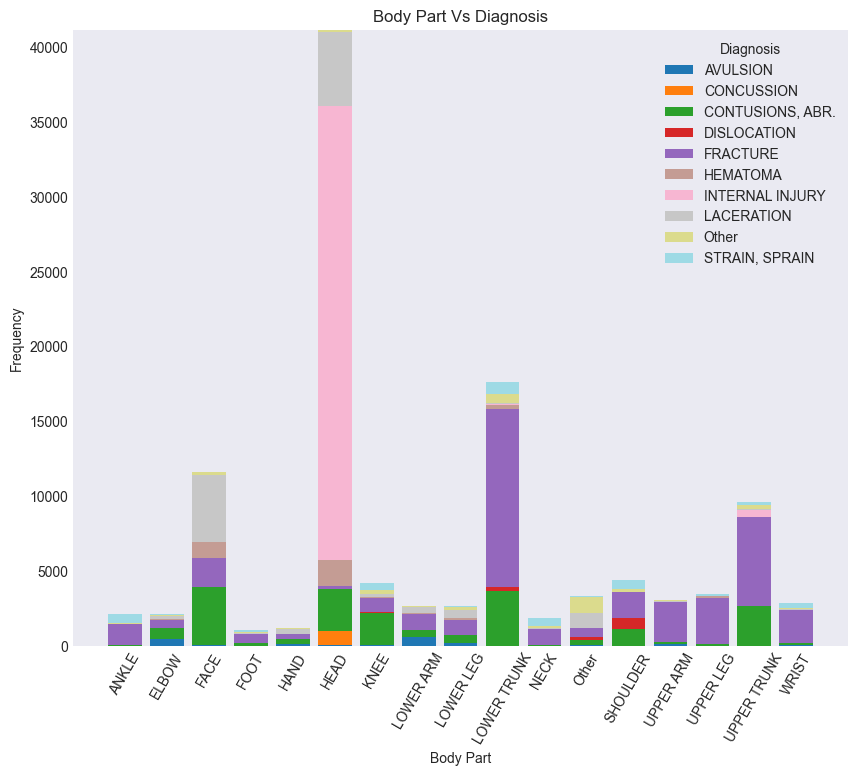

In [11]:
eda_matplotlib(primary_data, 'body_part_modified', 'diagnosis_modified', "Body Part Vs Diagnosis", "Body Part", 'Diagnosis')

### Disposition wrt Diagnosis

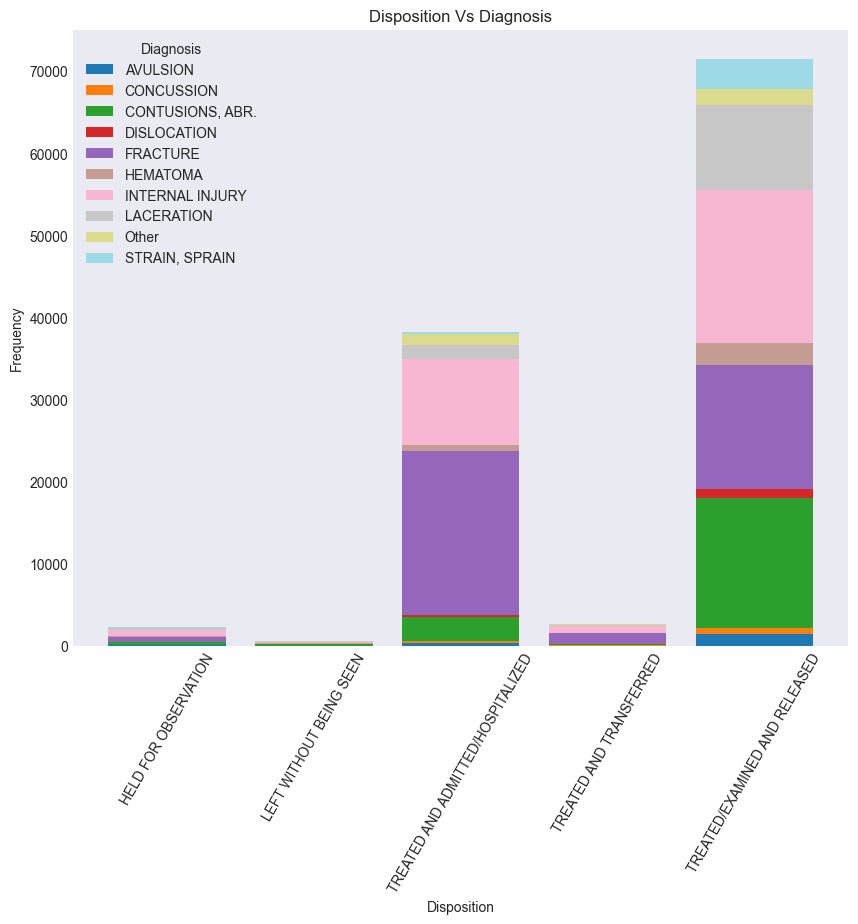

In [20]:
eda_matplotlib(primary_data, 'disposition', 'diagnosis_modified', 'Disposition Vs Diagnosis', 'Disposition', 'Diagnosis', 'upper left')

### Diagnosis Trend over Time

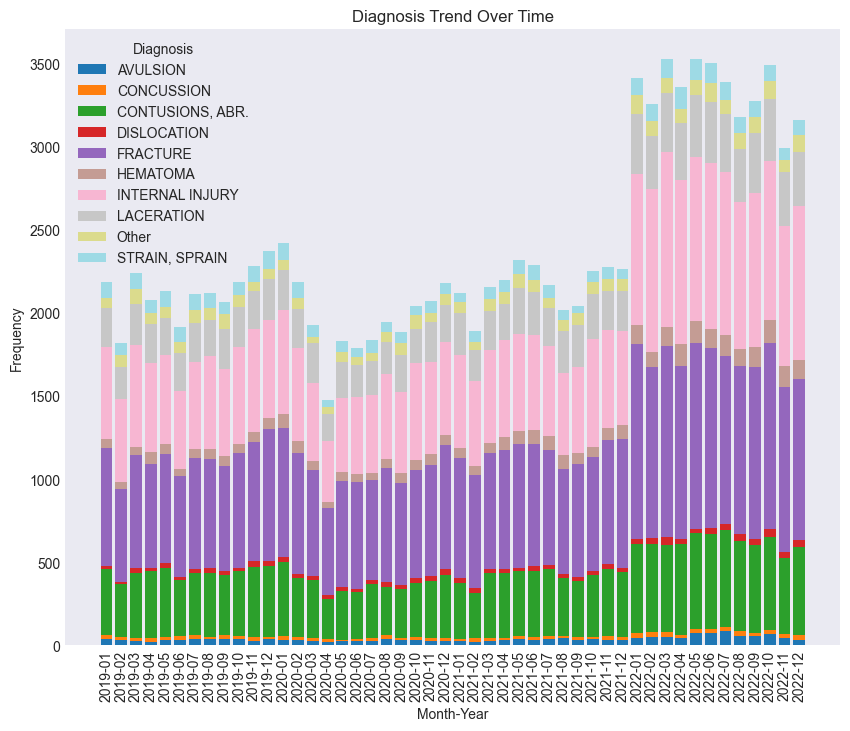

In [44]:
eda_matplotlib(trend_df, 'month_year', 'diagnosis_modified', 'Diagnosis Trend Over Time', 'Month-Year', 'Diagnosis', 'upper left', 90)

## Processing and cleaning the narratives

In [3]:
#Reading the medical terms mapping file
file_path = 'data/medical_terms_mapping.json'

with open(file_path, 'r') as json_file:
    medical_terms_mapping = json.load(json_file)

print(medical_terms_mapping)

{'c/o': 'complains of', 's/p': 'after', 'biba': 'brought in by ambulance', 'dx': 'clinical diagnosis', 'fx': 'fracture', 'fxs': 'fractures', 'inj': 'injury', 'sts': 'sit-to-stand', 'loc': 'loss of consciousness', 'at hm': 'at home', 'pt': 'patient', 'lac': 'laceration', 'chi': 'closed-head injury', 'af': 'accidental fall', 'abrs': 'abrasions', 'p/u': 'pick up', 'amb c': 'able to walk', "t'd&f": 'tripped and fell', "s'd&f": 'slipped and fell', 'br': 'bathroom', 'freq': 'frequent', 'uti': 'urinary tract infection', 'aki': 'acute kidney injury', 'fd': 'fall detected', "unwit'd": 'unwitnessed fall', 'trop': 'troponin', 'bwd': 'backward', 'etoh': 'ethyl alcohol', 'intox': 'intoxication', 'w': 'with', 'hx': 'history of', 'htn': 'hypertension', 'abras': 'abrasions', 'hd': 'head', 'clsd': 'closed', 'bac': 'blood alcohol content', '&': 'and', '***': '', '>>': 'clinical diagnosis', '@': 'at', 'abd': 'abdomen', 'afib': 'atrial fibrillation', 'am': 'morning', 'ams': 'altered mental status', 'bal':

In [4]:
#Function to clean & process the narratives
def clean_narratives(text):
    text = text.lower()

    # Unglue DX (diagnosis)
    regex_dx = r"([ˆ\W]*(dx)[ˆ\W]*)"
    text = re.sub(regex_dx, r". dx: ", text)

    # remove age and sex identifications
    # regex to capture age and sex
    regex_age_sex = r"(\d+)\s*?(yof|yf|yo\s*female|yo\s*f|yom|ym|yo\s*male|yo\s*m)"
    age_sex_match = re.search(regex_age_sex, text)

    #format age and sex
    if age_sex_match:
        age = age_sex_match.group(1)
        sex = age_sex_match.group(2)

        if "f" in sex:
            text = text.replace(age_sex_match.group(0), f"{age} years old female patient")
        elif "m" in sex:
            text = text.replace(age_sex_match.group(0), f"{age} years old male patient")

    # translate medical terms
    for term, replacement in medical_terms_mapping.items():
        if term == "@" or term == ">>" or term == "&" or term == "***":
            pattern = fr"({re.escape(term)})"
            text = re.sub(pattern, f" {replacement} ", text) # add spaces around replacement

        else:
            pattern = fr"(?<!-)\b({re.escape(term)})\b(?!-)"
            text = re.sub(pattern, replacement, text)

    return text

In [5]:
primary_data['cleaned_narrative'] = np.nan

In [7]:
tqdm.pandas(desc="Processing column1")
start = time.time()
primary_data['cleaned_narrative'] = primary_data['narrative'].apply(lambda x: clean_narratives(x))
end = time.time()
elapsed = end - start
print('Overall Time Elapsed:',elapsed)
print(str(timedelta(seconds=elapsed)))

Overall Time Elapsed: 54.57444357872009
0:00:54.574444


In [69]:
primary_data[['cpsc_case_number', 'narrative', 'cleaned_narrative']].head()

,cpsc_case_number,narrative,cleaned_narrative
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ONTO BACK OF HEAD SUSTAINED A SUBDURAL HEMATOMA,94 years old male patient fell to the floor at the nursing home onto back of head sustained a subdural hematoma
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED A CLOSED HEAD INJURY,86 years old male patient fell in the shower at home and sustained a closed head injury
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL TO THE FLOOR SUSTAINED ABRASIONS TO ELBOWS ADMITTED FOR HEMORRHAGIC STROKE,87 years old female patient was getting up from the couch and fell to the floor sustained abrasions to elbows admitted for hemorrhagic stroke
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WATER THAT WAS ON THE FLOOR AND SUSTAINED A RIGHT RADIUS FX,67 years old female patient was at a friends house and slipped on water that was on the floor and sustained a right radius fracture
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OFF SUSTAINED A RIGHT RADIUS FX,70 years old female patient was standing on a step stool and fell off sustained a right radius fracture


In [ ]:
primary_data.to_csv(r'data\cleaned_narrative_primary_data.csv', index=False)

## Selecting Representative Cases - using KMeans

### Loading the openAI embeddings

In [ ]:
file_path = 'data/openai_embeddings_primary_narratives.parquet.gzip'

In [7]:
# Open the Parquet file using pyarrow
table = pq.read_table(file_path)

# Convert the table to a Pandas DataFrame
embeddings_df = table.to_pandas()

In [8]:
display(embeddings_df.head(1))

,cpsc_case_number,embedding
0,190103269,"[-0.0006138611352071166, 0.003836937015876174, 0.002745086094364524, -0.02371806465089321, -0.018211619928479195, 0.020619874820113182, -0.0002926925662904978, -0.015373783186078072, -0.008012332022190094, 0.009938936680555344, 0.0004198175447527319, 0.04183856025338173, 0.01730038784444332, -0.0016402173787355423, -0.004657045938074589, 0.0023301499895751476, 0.015946557745337486, 0.021830512210726738, 0.013967882841825485, -0.01057679858058691, 0.00038544295239262283, 0.01702701859176159, 0.010401060804724693, 0.004855564329773188, 0.00017919536912813783, 0.015777328982949257, 0.007511154282838106, -0.017508668825030327, 0.019630538299679756, 0.00034903435152955353, -0.0016955421306192875, 0.012451332993805408, -0.022455357015132904, -0.023874275386333466, -0.016402173787355423, -0.0005361623479984701, -0.011019396595656872, -0.020281417295336723, -0.027753518894314766, 0.008975634351372719, 0.010811115615069866, -0.010453131049871445, 0.010485675185918808, -0.015243607573211193, -0.03241381794214249, -0.005942533724009991, -0.02268967404961586, -0.012197489850223064, -0.02268967404961586, 0.02042461186647415, 0.0023382860235869884, -0.003176294034346938, -0.01688382588326931, 0.015451889485120773, 0.005991349462419748, -0.017456598579883575, 0.02902924455702305, 0.010869694873690605, 0.008409368805587292, -0.013037124648690224, -0.0022780797444283962, -0.02215595170855522, -0.0012830470222979784, 0.028977174311876297, -0.026113301515579224, -0.0021316318307071924, -0.007042520679533482, -0.0048002395778894424, -0.0174175463616848, -0.004969468340277672, 0.05233074352145195, 0.019942959770560265, 0.0034333914518356323, 0.002178820548579097, 0.03181501105427742, -0.0026702347677201033, 0.004207938443869352, 0.011071467772126198, 0.014124094508588314, -0.009613496251404285, 0.02681625261902809, -0.03876640647649765, -0.029263561591506004, 0.027024533599615097, 0.024733437225222588, -0.01727435365319252, -0.011663768440485, 0.03142448142170906, 0.0032999610994011164, -0.011969681829214096, 0.02405652217566967, -0.004256754647940397, 0.011409925296902657, 0.007244293577969074, 0.00044341193279251456, 0.03189311549067497, -0.003915042616426945, 0.01992994360625744, 0.016558384522795677, -0.006059691775590181, ...]"


In [9]:
cleaned_narrative_with_embeddings = pd.merge(cleaned_narrative_primary_data,embeddings_df,on='cpsc_case_number', how='inner')

In [10]:
#Shape of each embedding
cleaned_narrative_with_embeddings['embedding'][0].shape

(1536,)

### Dimensionality Reduction

In [11]:
embedding_data = np.array(cleaned_narrative_with_embeddings['embedding'].values.tolist())
embedding_data.shape

(115128, 1536)

- Choosing the n_components as 200 because we are able to explain ~85% of the total variance using 200 dimensions. (For 95% explained variance the number of components (n_components) have to be >300)

In [12]:
n_components = 200

pca = PCA(n_components=n_components)

pca_result = pca.fit_transform(embedding_data)

explained_variances = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variances)

print("Explained variances by each component:", explained_variances)
print("Cumulative explained variance:", cumulative_explained_variance)

Explained variances by each component: [0.05982971 0.03246811 0.02810547 0.02635169 0.02261913 0.02151625
 0.01918103 0.01817125 0.01748737 0.01646777 0.0162477  0.01559173
 0.01454443 0.01378408 0.01353847 0.01199451 0.01178426 0.0111667
 0.01097926 0.01036031 0.00980657 0.00957704 0.00917827 0.00901579
 0.00858905 0.00841664 0.0081432  0.00797895 0.00758264 0.00750334
 0.00687654 0.00677323 0.006569   0.00651438 0.00629753 0.00607154
 0.0059631  0.00589081 0.0057872  0.0054467  0.00539082 0.00521375
 0.00508243 0.00492503 0.00484801 0.00466241 0.00453986 0.00447265
 0.00446419 0.00434366 0.00424916 0.0041633  0.00405514 0.00398259
 0.00395545 0.00384871 0.00382827 0.00376163 0.00374734 0.00360302
 0.0035744  0.00348266 0.00341959 0.00337255 0.003284   0.00323751
 0.00316105 0.00310061 0.00304292 0.00292937 0.00292365 0.00290702
 0.00287801 0.0027992  0.00277042 0.00270922 0.00266718 0.00264318
 0.00256551 0.00254065 0.00248963 0.00247547 0.00242183 0.00240017
 0.00237855 0.00236809 0

In [19]:
#Reduced embeddings
pca_result.shape

(115128, 200)

### Applying KMeans with number of clusters = 10000

- We want to identify 10k clusters with minimum intra-cluster variance and maximizing the inter-cluster distance

In [51]:
start = time.time()
kmeans = KMeans(n_clusters=10000)
kmeans.fit(pca_result)
cleaned_narrative_with_embeddings['cluster_label'] = kmeans.labels_
cleaned_narrative_with_embeddings.to_csv("data/k_means_cleaned_narrative_10k_clusters_200_dim.csv", index=False)

end = time.time()

elapsed = end - start
print('Overall Time Elapsed:',elapsed)
print(str(timedelta(seconds=elapsed)))

Overall Time Elapsed: 4391.254518985748
1:13:11.254519


In [11]:
clusters_data = pd.read_csv("data/k_means_cleaned_narrative_10k_clusters_200_dim.csv")

In [12]:
embedding_clusters = pd.merge(cleaned_narrative_with_embeddings[['cpsc_case_number', 'embedding']], clusters_data[['cluster_label', 'cpsc_case_number']] , on = 'cpsc_case_number')

In [55]:
def get_closest_sample(df_filtered):
    if len(df_filtered)==1:
        return df_filtered['cpsc_case_number'].values[0]
    df_filtered = df_filtered.reset_index(drop=True)
    
    mean_array = np.mean(df_filtered['embedding'].values, axis=0)
    
    cosine_similarities = np.dot(np.array(df_filtered['embedding'].values.tolist()), mean_array)

    # Find the index of the vector with the highest cosine similarity
    closest_index = np.argmax(cosine_similarities)
    
    return df_filtered['cpsc_case_number'].values[closest_index]
    

In [57]:
cpsc_sample_list = []
cluster_sample_list = []
for k,v in embedding_clusters.groupby('cluster_label'):
    cpsc = get_closest_sample(v)
    cpsc_sample_list.append(cpsc)
    cluster_sample_list.append(k)

In [ ]:
df_sample = pd.DataFrame({'cpsc_case_number':cpsc_sample_list, 'cluster_label':cluster_sample_list})

In [64]:
sample_data_10k = pd.merge(df_sample, cleaned_narrative_with_embeddings, on='cpsc_case_number', how='left')

In [109]:
sample_data_10k.to_csv('data/sample_data_10k.csv', index=False)

## Creating golden/training dataset for severity (using Llama 2 LLM)

### Installing Llama 2 on GPU

In [1]:
# GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 --force-reinstall --upgrade --no-cache-dir --verbose
# For download the models
!pip install huggingface_hub

### Downloading the llama 2 model

In [ ]:
model_name_or_path = "TheBloke/Llama-2-7B-chat-GGML"
model_basename = "llama-2-7b-chat.ggmlv3.q4_0.bin" # the model is in bin format

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

### Loading the model on GPU

In [ ]:
# Loading on GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
  n_threads=2, # CPU cores
    n_batch=516, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=10000, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=2048
    )


In [ ]:
data = pd.read_csv('data/sample_data_10k.csv')

### Defining the prompt for Llama 2 model

In [ ]:
def create_prompt(prompt,incident):

    prompt_template=f'''SYSTEM: Classify the severity of falls based on narratives.
User: Please classify the severity of the reported injury for an elderly patient in the incident report into one of the following categories:
- "Very Severe": Life-threatening with long-term effects
- "Severe": Not life-threatening but requiring multiple days of hospitalization
- "Moderate": Requires a doctor's visit but no hospitalization
- "Minor": No hospitalization or doctor's visit needed
Severity Classification: [Very Severe/Severe/Moderate/Minor]

Fall Narrative: {incident}
Assistant:'''
    
    return prompt_template

### Getting the predictions from Llama 2 for representative data (10k)

In [2]:
results=[]
for i in range(data.shape[0]):
    try:
        prompt=create_prompt('',data.narrative.values[i]+'.')

        response=lcpp_llm(prompt=prompt, max_tokens=800, temperature=0, top_p=0.9,
                      repeat_penalty=1.2, top_k=1,
                      echo=False)
        result=response["choices"][0]["text"]

        results.append(result)
        
    except Exception as e:
        print(f"Error {e} occurred at count = {i}")
        results.append(None)
        
        

final_data=data[['cpsc_case_number']].copy()
final_data['severity']=results

In [ ]:
final_list=[]
for i in final_data.severity:
    try:
        pattern = r'\b(Very Severe|Severe|Moderate|Minor)\b'
        matches = re.findall(pattern, i)
        final_list.append(matches[0])
    except:
        final_list.append('Not Found')

In [ ]:
final_data['severity_of_fall']=final_list
final_data.drop(columns=['severity'], inplace=True)

In [ ]:
final_data.to_csv('data/severity_data_10k.csv',index=False)

## Creating golden/training dataset for Reason of Fall - using OpenAI ChatGPT

### Installing OpenAI

In [ ]:
!pip install openai

In [ ]:
openai.api_key= 'INSERT_YOUR_API_KEY'

### Defining the User & System Prompts for Turbo 3.5 model

In [ ]:
user_prompt = """Below are some common reasons associated with falls of elderly people - 

- Medical and Health Factors like chronic medical conditions (e.g., arthritis, stroke, Parkinson's, dementia, Alzheimer's, \
incontinence, postural hypotension), medications (sedatives, antidepressants, cardiovascular drugs, polypharmacy), cognitive \
and psychological factors (depression, cognitive impairment, memory loss).

- Demographic and Lifestyle Factors like age-related factors (older age, gender), living situation (living alone, \
housebound), reduced physical activity/exercise, history of falls.

- Sensory and Perception Factors like impaired vision (visual acuity, perceptual errors), impaired hearing.

- Environmental Factors like home hazards (for eg - wet floor, carpet, rug, item on floor) , environmental hazards (for eg - uneven roads, things on floor, etc).

- Behavioral Factors like risky behaviors, alcohol use with medication, bladder or bowel conditions.

- Physical Factors like Lower body weakness, reduced strength (knee, hip, ankle, grip), pain/arthritis (hip, knee), \
sensory impairments (visual acuity, depth perception, lower extremity sensory function), gait and balance issues.

### Narrative Text
{text}

Based on the narrative text above, can you choose the most appropriate reason of fall from the above options ? Format the output in the form of a json as
{<reason> : <explanation>}

Output only the json text."""

system_message = """You are a bot designed to identify the most appropriate reason of fall based on the Narrative Text."""

### Defining functions to call the Chat Completion API

In [3]:
def get_completion_from_messages(messages, model="gpt-3.5-turbo", temperature=0):
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

In [4]:
def get_message(user_message, system_message):
    messages =  [
        {'role':'system', 'content': system_message},
        {'role':'user', 'content':user_message}]
    return messages

### Getting predictions from OpenAI ChatGPT for representative data (10k)

In [ ]:
json_extraction_pattern = r'\{[^{}]*\}'
reason_results=[]
explanation_results = []

for i in range(data.shape[0]):
    try:
        narrative = data.cleaned_narrative.values[i]
        user_message = user_prompt.replace('{text}', narrative)
        response = get_completion_from_messages(get_message(user_message, system_message))

        response_json = re.findall(json_extraction_pattern, response)[0]

        response_dict = json.loads(response_json)
        reason_of_fall = list(response_dict.keys())[0]
        explanation = list(response_dict.values())[0]

        reason_results.append(reason_of_fall)
        explanation_results.append(explanation)

    except Exception as e:
        print(f"Error {e} occurred at count = {i}")
        print(f"Narrative Text is \n{narrative}")
        reason_results.append("NA")
        explanation_results.append("NA")
        
    time.sleep(20)

temp_data=data[['cpsc_case_number']].copy()
temp_data['reason_of_fall'] = reason_results
# temp_data['reason_explanation'] = explanation_results
temp_data.to_csv('data/reason_of_fall_data_10k.csv',index=False)

## Creating golden/training dataset for Action before Fall - using OpenAI ChatGPT

### Defining the User & System Prompts for Turbo 3.5 model

In [5]:
user_prompt = """Below are different activities which elderly people tend to perform leading to their fall -

Assisted Mobility Activities : Activities that involve the use of different mobility aids or assistance such as using a \
walker, wheelchair , etc.

Walking and Gait Activities : Activities that involve walking, running and maintaining an upright posture.

Stair Mobility Activities : Activities that involve climbing or descending the stairs/steps.

Bathroom Activities : Activities that involve bathroom or using the washroom/toilet facilities.

Bedroom Activities : Activities that involve bed or are associated with the bedroom.

Household Activities : Activities that involve household, household chores or that took place inside the home.

Outdoor Activities : Activities that involve anything happening outside the house or outdoors.

Special Leisure Activities : Activities that involve unusual events and recreational/leisure activities.

Other Miscellaneous Activities : Activities that do not fall under any of the above categories.

Unknown Activities : If no activity can be identified from the narrative text.

### Narrative Text
{text}


Based on the narrative text given above, can you choose one of the activities the person was performing just before the \
fall. Respond in the form of a json as 

{<Activity before fall> : <explanation>}

Output only the json text."""

system_message = """You are an expert in identifying and classifying the action performed by the person just before the fall based on the Narrative Text given"""

### Getting predictions from OpenAI ChatGPT for representative data (10k)

In [ ]:
json_extraction_pattern = r'\{[^{}]*\}'
action_before_fall_results=[]
explanation_results = []

for i in range(data.shape[0]):
    try:
        narrative = data.cleaned_narrative.values[i]
        user_message = user_prompt.replace('{text}', narrative)
        response = get_completion_from_messages(get_message(user_message, system_message))

        response_json = re.findall(json_extraction_pattern, response)[0]

        response_dict = json.loads(response_json)
        action_before_fall = list(response_dict.keys())[0]
        explanation = list(response_dict.values())[0]

        action_before_fall_results.append(action_before_fall)
        explanation_results.append(explanation)

    except Exception as e:
        print(f"Error {e} occurred at count = {i}")
        print(f"Narrative Text is \n{narrative}")
        action_before_fall_results.append("NA")
        explanation_results.append("NA")
        
    time.sleep(20)

temp_data=data[['cpsc_case_number']].copy()
temp_data['action_before_fall'] = action_before_fall_results
# temp_data['action_before_fall_explanation'] = explanation_results
temp_data.to_csv('data/action_before_fall_data_10k.csv',index=False)

## Building a Classifier - Training DistilBERT on Golden Data

### Installing & Loading DistilBERT

In [ ]:
!pip install numpy==1.23.5 --user
!pip install transformers[torch]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [6]:
from sklearn.model_selection import train_test_split

### Creating a Classifier for Severity

- Loading the severity training data

In [ ]:
train_data = pd.read_csv('data/severity_data_10k.csv')

In [ ]:
sample_data_10k = pd.read_csv('data/sample_data_10k.csv')
train_data = sample_data_10k.merge(train_data, on='cpsc_case_number', how='left')

In [ ]:
train_data = train_data[['cleaned_narrative', 'severity_of_fall']]
train_data.columns=['text','label']


#### Label Encoding

In [ ]:
label2id = dict(zip(sorted(train_data.label.unique()), range(len(train_data.label.unique()))))
id2label = {v:k for k,v in label2id.items()}

In [ ]:
train_data['label']=train_data['label'].apply(lambda x:label2id[x])

In [ ]:
train_data.head()

,text,label
0,88 years old female patient fell on floor. com...,2
1,78 years old female patient fell to the floor ...,3
2,77 years old female patient was walking with a...,2
3,77 years old female patient patient rolled out...,2
4,65 years old female patient presents after she...,1


In [ ]:
X = train_data.drop('label', axis = 1)
y = train_data['label']

#### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y)

In [ ]:
X_train['label'] = y_train
X_test['label'] = y_test

In [ ]:
X_train.to_csv('data/Bert_train.csv', index=False)
X_test.to_csv('data/Bert_test.csv', index=False)

In [ ]:
! pip install datasets

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset('csv', data_files={'train': 'data/Bert_train.csv',
                                          'test': 'data/Bert_test.csv'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8955
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 996
    })
})

#### Preprocess the dataset

In [ ]:
from transformers import DataCollatorWithPadding

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True,padding=True)

tokenized_data = dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#### Function to compute F1-Score

In [ ]:
from sklearn.metrics import f1_score

def compute_f1(pred):
    # Extract predicted labels and true labels from the prediction tuple
    predictions, labels = pred.predictions, pred.label_ids

    # Calculate F1 score
    f1 = f1_score(y_true=labels, y_pred=predictions.argmax(axis=1), average='macro')

    return {"f1": f1}

In [ ]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8955
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 996
    })
})

#### Training DistilBERT model for n epochs

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

#Number of labels
n_labels = len(list(label2id.keys()))

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=n_labels, id2label=id2label, label2id=label2id).to("cuda")

training_args = TrainingArguments(
    output_dir="data/models",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=2000,
    save_strategy="steps",
    save_steps=4000,
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_f1,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1
2000,0.239800,0.470649,0.522936
4000,0.104900,0.672589,0.530060
6000,0.054200,0.936297,0.703524
8000,0.034800,1.114220,0.687363
10000,0.022000,1.169410,0.686619
12000,0.017400,1.196337,0.524696
14000,0.014800,1.290930,0.698542
16000,0.008500,1.359721,0.674937
18000,0.014800,1.393266,0.686123
20000,0.006100,1.438321,0.682640


#### Loading the last best checkpoint of the model

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="data/models/checkpoint-20000/", device=0) #Setting device=0 to enable GPU

#### Making predictions on the whole dataset

In [ ]:
predict_data=pd.read_csv('data/cleaned_narrative_primary_data.csv')

predicted_outputs = []
# Define the batch size for processing multiple texts at once
batch_size = 1000

# Iterate over the dataframe in batches
for i in range(0, predict_data.shape[0], batch_size):
    print(i)
    batch_texts = predict_data['cleaned_narrative'].iloc[i:i+batch_size].tolist()

    results=classifier(batch_texts)     
    results=[i['label'] for i in results]
    predicted_outputs.extend(results)   
    
predict_data['severity']=predicted_outputs
predict_data[['cpsc_case_number', 'severity_of_fall']].to_csv('data/severity_whole_data.csv', index=False)

- Similar to the classification model trained for severity of fall, we have trained two more classification models namely for classifying the action before fall and reason of fall.

## Collating the data and Generating Insights
- Deep Exploratory Data Analysis

### Reading the data after making predictions

In [ ]:
action_before_fall_10k = pd.read_csv("data/action_before_fall_data_10k.csv")
action_before_fall_100k = pd.read_csv("data/action_before_fall_whole_data.csv")

reason_of_fall_10k = pd.read_csv("data/reason_of_fall_data_10k.csv")
reason_of_fall_100k = pd.read_csv("data/reason_of_fall_whole_data.csv")

severity_of_fall_10k = pd.read_csv("data/severity_data_10k.csv")
severity_of_fall_100k = pd.read_csv("data/severity_whole_data.csv")

In [ ]:
falls_valid_category = ["Assisted Mobility Activities",
"Walking and Gait Activities",
"Stair Mobility Activities",
"Bathroom Activities",
"Bedroom Activities",
"Household Activities",
"Outdoor Activities",
"Special Leisure Activities",
"Other Miscellaneous Activities",
"Unknown Activities"]

severity_valid_category = ['Severe', 'Very Severe', 'Moderate', 'Minor']

In [35]:
severity_of_fall_10k = severity_of_fall_10k[severity_of_fall_10k['severity_of_fall'].isin(severity_valid_category)]
severity_of_fall_10k.shape

(9951, 2)

In [25]:
action_before_fall_10k = action_before_fall_10k[action_before_fall_10k['action_before_fall'].isin(falls_valid_category)]
action_before_fall_10k.shape

(9974, 2)

In [27]:
action_before_fall_10k.shape, action_before_fall_100k.shape

((9974, 2), (115128, 2))

In [28]:
reason_of_fall_10k.shape, reason_of_fall_100k.shape

((10000, 2), (115128, 2))

In [57]:
severity_of_fall_10k.shape, severity_of_fall_100k.shape

((9951, 2), (115128, 2))

In [37]:
action_before_fall_final = pd.concat([action_before_fall_10k, action_before_fall_100k[~action_before_fall_100k['cpsc_case_number'].isin(action_before_fall_10k['cpsc_case_number'].unique())]])

In [40]:
severity_of_fall_final = pd.concat([severity_of_fall_10k, severity_of_fall_100k[~severity_of_fall_100k['cpsc_case_number'].isin(severity_of_fall_10k['cpsc_case_number'].unique())]])

In [44]:
reason_of_fall_final = pd.concat([reason_of_fall_10k, reason_of_fall_100k[~reason_of_fall_100k['cpsc_case_number'].isin(reason_of_fall_10k['cpsc_case_number'].unique())]])

In [49]:
action_reason = pd.merge(action_before_fall_final, reason_of_fall_final, on='cpsc_case_number', how='left')

In [51]:
action_reason_severity = pd.merge(action_reason, severity_of_fall_final, on='cpsc_case_number', how='left')

In [54]:
final_data = pd.merge(cleaned_narrative_primary_data, action_reason_severity, on='cpsc_case_number', how='left')

In [56]:
final_data.head(10)

,narrative,treatment_date,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,...,drug,product_1,product_2,product_3,cpsc_case_number,age,cleaned_narrative,action_before_fall,reason_of_fall,severity_of_fall
0,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,NaN,NaN,...,No/Unk,FLOORS OR FLOORING MATERIALS,None,None,190103269,94,94 years old male patient fell to the floor at...,Unknown Activities,Medical and Health Factors,Very Severe
1,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,NaN,NaN,...,No/Unk,BATHTUBS OR SHOWERS,None,None,190103270,86,86 years old male patient fell in the shower a...,Bathroom Activities,Medical and Health Factors,Severe
2,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,NaN,NaN,...,No/Unk,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,None,190103273,87,87 years old female patient was getting up fro...,Unknown Activities,Medical and Health Factors,Severe
3,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,NaN,NaN,...,No/Unk,FLOORS OR FLOORING MATERIALS,None,None,190103291,67,67 years old female patient was at a friends h...,Unknown Activities,Environmental Factors,Severe
4,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,NaN,NaN,...,No/Unk,STEP STOOLS,None,None,190103294,70,70 years old female patient was standing on a ...,Stair Mobility Activities,Physical Factors,Severe
5,79YOM WAS STANDING ON A FOLDING LAWN CHAIR AND...,2019-01-01,MALE,N.S.,NaN,Unk/Not stated,CONCUSSION,NaN,NaN,NaN,...,No/Unk,BEACH CHAIRS OR FOLDING CHAIRS,None,None,190103298,79,79 years old male patient was standing on a fo...,Outdoor Activities,Physical Factors,Severe
6,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,2019-01-01,MALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,NaN,NaN,...,No/Unk,GREENHOUSE OR GARDENING SUPPLIES,None,None,190103309,74,74 years old male patient fell into a planter ...,Outdoor Activities,Physical Factors,Severe
7,76YOF HAD A SLIP AND FALL AT HOME STRUCK HEAD ...,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,NaN,NaN,...,No/Unk,FLOORS OR FLOORING MATERIALS,None,None,190103337,76,76 years old female patient had a slip and fal...,Unknown Activities,Physical Factors,Severe
8,84YOF FELL WHILE GETTING UP FROM THE COUCH AND...,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,NaN,NaN,...,No/Unk,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",None,None,190103340,84,84 years old female patient fell while getting...,Unknown Activities,Physical Factors,Severe
9,88YOF FELL TO THE FLOOR AT HOME UNRESPONSIVE S...,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,NaN,NaN,...,No/Unk,FLOORS OR FLOORING MATERIALS,None,None,190103341,88,88 years old female patient fell to the floor ...,Unknown Activities,Medical and Health Factors,Very Severe


In [58]:
final_data.to_csv("data/final_combined_data.csv", index=False)

### Combining variables having multiple categories (for finding relationships in the data)

In [321]:
selected_body_parts = ['HEAD', 'LOWER TRUNK', 'FACE', 'UPPER TRUNK', 'SHOULDER', 'KNEE', 'UPPER LEG', 'UPPER ARM', 'WRIST', 'LOWER ARM', 'LOWER LEG', 'ANKLE', 'ELBOW', 'NECK', 'HAND', 'FOOT']
final_data['body_part_modified']= final_data['body_part'].apply(lambda x: x if x in selected_body_parts else 'Other')

selected_diagnosis = ['FRACTURE', 'INTERNAL INJURY', 'CONTUSIONS, ABR.', 'LACERATION', 'STRAIN, SPRAIN', 'HEMATOMA', 'AVULSION', 'DISLOCATION', 'CONCUSSION']
final_data['diagnosis_modified']= final_data['diagnosis'].apply(lambda x: x if x in selected_diagnosis else 'Other')

selected_body_parts = ['HEAD', 'LOWER TRUNK', 'FACE', 'UPPER TRUNK', 'SHOULDER', 'KNEE', 'UPPER LEG', 'UPPER ARM', 'WRIST', 'LOWER ARM', 'LOWER LEG', 'ANKLE', 'ELBOW', 'NECK', 'HAND', 'FOOT']
final_data['body_part_2_modified']= final_data['body_part_2'].apply(lambda x: x if x in selected_body_parts else 'Other')

selected_diagnosis = ['FRACTURE', 'INTERNAL INJURY', 'CONTUSIONS, ABR.', 'LACERATION', 'STRAIN, SPRAIN', 'HEMATOMA', 'AVULSION', 'DISLOCATION', 'CONCUSSION']
final_data['diagnosis_2_modified']= final_data['diagnosis_2'].apply(lambda x: x if x in selected_diagnosis else 'Other')

In [322]:
final_data.head()

,narrative,treatment_date,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,cpsc_case_number,age,cleaned_narrative,action_before_fall,reason_of_fall,severity_of_fall,age_group,product_modified,body_part_modified,diagnosis_modified,body_part_2_modified,diagnosis_2_modified
0,94YOM FELL TO THE FLOOR AT THE NURSING HOME ONTO BACK OF HEAD SUSTAINED A SUBDURAL HEMATOMA,2019-01-01,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,NaN,NaN,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,None,None,190103269,94,94 years old male patient fell to the floor at the nursing home onto back of head sustained a subdural hematoma,Unknown Activities,Medical and Health Factors,Very Severe,90-94,FLOORS OR FLOORING MATERIALS,HEAD,INTERNAL INJURY,Other,Other
1,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED A CLOSED HEAD INJURY,2019-01-01,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,NaN,NaN,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,BATHTUBS OR SHOWERS,None,None,190103270,86,86 years old male patient fell in the shower at home and sustained a closed head injury,Bathroom Activities,Medical and Health Factors,Severe,85-89,BATHTUBS OR SHOWERS,HEAD,INTERNAL INJURY,Other,Other
2,87YOF WAS GETTING UP FROM THE COUCH AND FELL TO THE FLOOR SUSTAINED ABRASIONS TO ELBOWS ADMITTED FOR HEMORRHAGIC STROKE,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,NaN,NaN,ELBOW,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO COUCHES",FLOORS OR FLOORING MATERIALS,None,190103273,87,87 years old female patient was getting up from the couch and fell to the floor sustained abrasions to elbows admitted for hemorrhagic stroke,Unknown Activities,Medical and Health Factors,Severe,85-89,Other,ELBOW,"CONTUSIONS, ABR.",Other,Other
3,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WATER THAT WAS ON THE FLOOR AND SUSTAINED A RIGHT RADIUS FX,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,NaN,NaN,LOWER ARM,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,None,None,190103291,67,67 years old female patient was at a friends house and slipped on water that was on the floor and sustained a right radius fracture,Unknown Activities,Environmental Factors,Severe,65-69,FLOORS OR FLOORING MATERIALS,LOWER ARM,FRACTURE,Other,Other
4,70YOF WAS STANDING ON A STEP STOOL AND FELL OFF SUSTAINED A RIGHT RADIUS FX,2019-01-01,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,NaN,NaN,LOWER ARM,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,STEP STOOLS,None,None,190103294,70,70 years old female patient was standing on a step stool and fell off sustained a right radius fracture,Stair Mobility Activities,Physical Factors,Severe,70-74,Other,LOWER ARM,FRACTURE,Other,Other


### Creating Age Buckets

In [ ]:
bins = list(range(65, 131, 5))

labels = [f'{start}-{end-1}' for start, end in zip(bins[:-1], bins[1:])]

final_data['age_group'] = pd.cut(final_data['age'], bins=bins, labels=labels, right=False)

### Analyzing Very Severe Cases of Fall wrt Age Buckets

In [88]:
temp_df = final_data[final_data['severity_of_fall']=='Very Severe']
temp_df.shape

(17312, 27)

In [91]:
severity_df = final_data[['severity_of_fall', 'age_group']]
severity_df.head()

,severity_of_fall,age_group
0,Very Severe,90-94
1,Severe,85-89
2,Severe,85-89
3,Severe,65-69
4,Severe,70-74


In [94]:
severe_groups = severity_df.groupby('age_group')

In [374]:
severe_perc_df = pd.DataFrame()
for group,data in severe_groups:
    print(group)
    count_df = data.value_counts().to_frame().reset_index()
    count_df['percentage'] = np.nan
    count_df['percentage'] = count_df[0]/sum(list(count_df[0]))
    severe_perc_df = pd.concat([severe_perc_df, count_df])    

65-69
70-74
75-79
80-84
85-89
90-94
95-99
100-104
105-109
110-114
115-119
120-124
125-129


In [109]:
very_severe_df = severe_perc_df[severe_perc_df['severity_of_fall']=='Very Severe']
very_severe_df

,severity_of_fall,age_group,0,percentage
1,Very Severe,65-69,2548,0.134958
1,Very Severe,70-74,2934,0.142089
1,Very Severe,75-79,2885,0.140649
1,Very Severe,80-84,3020,0.152279
1,Very Severe,85-89,2833,0.160674
1,Very Severe,90-94,2129,0.173555
1,Very Severe,95-99,819,0.178704
1,Very Severe,100-104,133,0.189189
1,Very Severe,105-109,11,0.161765


### Analyzing Distribution of Very Severe Cases wrt Age Group

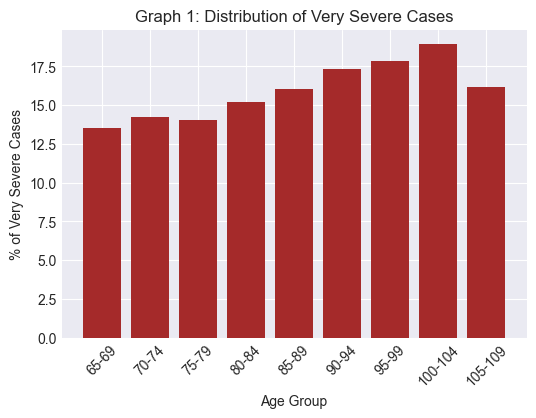

In [372]:
# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(very_severe_df['age_group'], very_severe_df['percentage']*100, color='brown')
plt.xlabel('Age Group')
plt.ylabel('% of Very Severe Cases')
plt.title('Graph 1: Distribution of Very Severe Cases')

plt.xticks(rotation=45)
plt.show()


### Plotting Graphs using Matplotlib - Stacked Bar Chart (Bivariate/Cross Tab Analysis)

In [356]:
def eda_matplotlib(data, var1, var2, title=None, xaxis_title=None, legend_title=None, loc='upper right', rotation=60, calc_percentage = False):
    cross_tab = pd.crosstab(data[var1], data[var2])
    categories = cross_tab.columns
    
    # Create a list of colors for each category
    colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))
    
    # Initialize bottom values for stacking
    bottom = [0] * len(cross_tab.index)
    
    plt.style.use('seaborn-darkgrid') 
    
    fig, ax = plt.subplots(figsize=(5,3))
    
    if calc_percentage:
        cross_tab = cross_tab.apply(lambda x: x / x.sum(), axis=1)
        # Iterate through categories and plot bars
        for i, category in enumerate(categories):
            counts = cross_tab[category]
            bars = plt.bar(cross_tab.index, counts, bottom=bottom, label=category, color=colors[i])
            bottom += counts
        # Add legend with loc
        plt.legend(title=legend_title, loc= loc, bbox_to_anchor=(1, 1))

    else :  
        # Iterate through categories and plot bars
        for i, category in enumerate(categories):
            counts = cross_tab[category]
            bars = plt.bar(cross_tab.index, counts, bottom=bottom, label=category, color=colors[i])
            bottom += counts
        # Add legend with loc
        plt.legend(title=legend_title, loc= loc)
    
    # Add labels and title
    plt.ylabel('Frequency')
    plt.title(title)

    # Set x-axis label if provided
    if xaxis_title:
        ax.set_xlabel(xaxis_title)

    plt.xticks(rotation=rotation, ha = 'left')
    
    # Remove gridlines
    plt.grid(False)
    plt.show()

### Analyzing Body Part wrt Severity

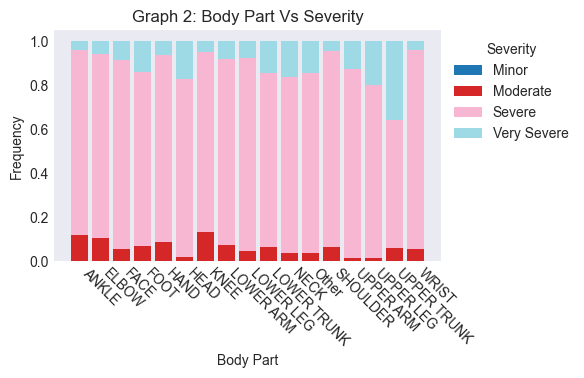

In [371]:
eda_matplotlib(final_data, 'body_part_modified', 'severity_of_fall', 'Graph 2: Body Part Vs Severity', 'Body Part', legend_title='Severity', rotation=-45, loc='upper left', calc_percentage=True )

### Analyzing Age Group wrt Action Before Fall

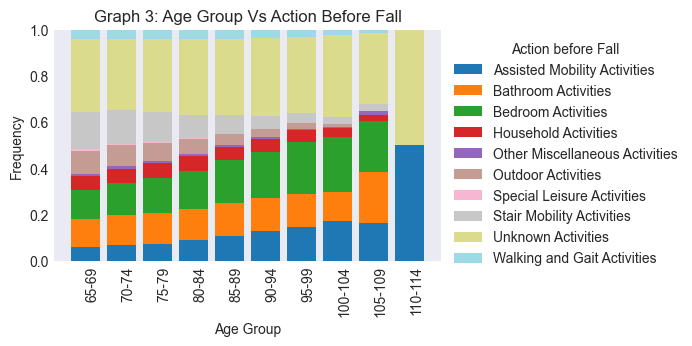

In [366]:
eda_matplotlib(final_data, 'age_group', 'action_before_fall', 'Graph 3: Age Group Vs Action Before Fall', 'Age Group', legend_title='Action before Fall', rotation=90, loc='upper left', calc_percentage=True )

### Analyzing Action Before Fall wrt Severity

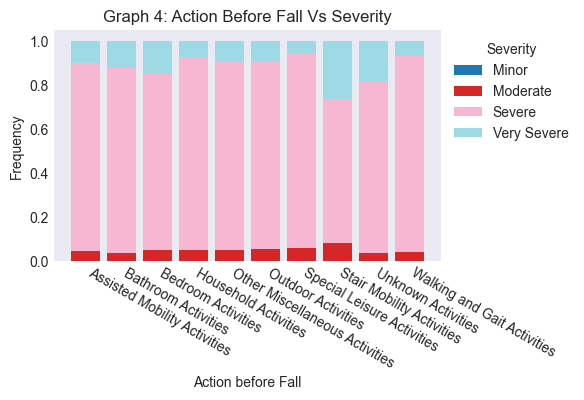

In [362]:
eda_matplotlib(final_data, 'action_before_fall', 'severity_of_fall', 'Graph 4: Action Before Fall Vs Severity', 'Action before Fall', legend_title='Severity', rotation=-30, loc='upper left', calc_percentage=True )

### Analyzing Risk Factors wrt Severity

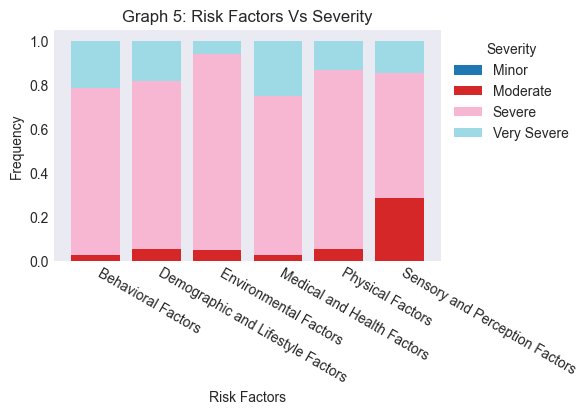

In [373]:
eda_matplotlib(final_data, 'reason_of_fall', 'severity_of_fall', 'Graph 5: Risk Factors Vs Severity', 'Risk Factors', 'Severity', rotation=-30, loc='upper left', calc_percentage=True )

## NULL Result Section

*What Didn’t work?*
- BERTopic with hyperparameter tuning: Unable to get insights since most of the data getting clustered as noise.
- KMeans Clustering: Hard to find the K for KMeans and clusters were not homogeneous.
- FLAN-T5 for generating Severity, reason, and action before fall: Very low accuracy for zero shot classification.
- XGBoost Model for training on Gold Data and Predicting: Much lower accuracy after manual Validation

### Applying BERTopic for Topic Modelling

In [2]:
# !pip install bertopic

In [ ]:
import random

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


from bertopic import BERTopic

import spacy
import nltk
nltk.download('stopwords')

import pyarrow.parquet as pq

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired, TextGeneration, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
from transformers import pipeline

In [ ]:
def fit_topic_model_v2(filtered_df, stop_words, on_column = "cleaned_text", embedding_column = "embedding",
                   language="english"):

    dialogue_list = filtered_df[on_column].tolist()
    openai_embeddings = np.array(filtered_df[embedding_column].tolist())
    print("Embeddings dimensions : ", openai_embeddings.shape)
    
    #Tuned Parameters (saved as bert_topic_model_20230904_v7.pickle)
    vectorizer_model = CountVectorizer(stop_words=stop_words)
    ctfidf_model = ClassTfidfTransformer(
            reduce_frequent_words=True)
    umap_model = UMAP(n_neighbors=15, n_components=100, min_dist=0.0, metric='cosine', random_state=0,  low_memory=True)
    hdbscan_model = HDBSCAN(min_samples=1, cluster_selection_method='leaf', prediction_data=True)
    representation_model = MaximalMarginalRelevance(diversity=0.4)
    topic_model = BERTopic(representation_model=representation_model, language=language, umap_model=umap_model, hdbscan_model = hdbscan_model, vectorizer_model=vectorizer_model,
                           ctfidf_model= ctfidf_model, calculate_probabilities=True, nr_topics=10000, min_topic_size=500)
    topics, probs = topic_model.fit_transform(dialogue_list, embeddings= openai_embeddings)
    topic_model.save('model/bert_topic_model_20230908_v1.pickle')
    # new_topics = topic_model.reduce_outliers(dialogue_list, topics)
    print("Total Topics: ", len(dict(topic_model.get_topic_info()["Name"])))
    return topic_model, topic_model.get_topic_info()


In [ ]:
start = time.time()
topic_model, topic_info = fit_topic_model_v2(cleaned_narrative_with_embeddings, stop_words = english_stopwords, on_column = "cleaned_narrative",
      embedding_column = 'embedding',  language="english")
end = time.time()
elapsed = end - start
print('Overall Time Elapsed:',elapsed)
print(str(timedelta(seconds=elapsed)))
topic_info.head()

In [ ]:
topic_model = BERTopic.load('model/bert_topic_model_20230908_v1.pickle')

In [14]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,25376,-1_forehead_face_abrasion_hit,"[forehead, face, abrasion, hit, laceration, hitting, elbow, presents, tripped, hand]","[89 years old female patient with complains of laceration to forehead after unwitnessed fall. patient reports she fell today at home and hit head on floor. clinical diagnosis: facial laceration; injury of head; fall, 82 years old male patient presents to ed for co fall while in shower patient had non syncopal fall in shower patient lost balance and slipped and fell hitting elbow and back of head left hip and low left foot co elbow pain with laceration and bleeding present. clinical diagnosis: left elbow contusion, left elbow laceration, closed head injury with scalp hematoma, left toe contusion, 79 years old female patient complains of fell down 2 steps at home today hitting her head against the wall. clinical diagnosis: closed head injury, laceration scalp, contusion right wrist]"
1,0,38364,0_hip_knee_femur_shoulder,"[hip, knee, femur, shoulder, nursing, ankle, humerus, right, leg, left]","[79 years old female patient patient was at home, she was trying to get her slipper on her foot last night when she lost her balance and fell onto her right side, suffered an injury to her right ankle. clinical diagnosis: fall, closed bimalleolar fracture of right ankle,contusion of right hip, contusion of right knee, 74 years old female patient to emergency room for post fall evaluation from fall at home, patient fell on carpet onto left hip, patient also has skin tear on left lower leg. clinical diagnosis: left hip pain, closed fracture of left pelvis, skin tear left lower leg, 84 years old male patient was trying to walk and had a slip and fall onto head at the nursing home fell to the floor. clinical diagnosis: closed head injury skin tear to right lower arm]"
2,1,15687,1_scalp_face_facial_injury,"[scalp, face, facial, injury, hit, laceration, head, closed, hematoma, striking]","[92 years old male patient had a slip and fall striking his head on a chair at home. clinical diagnosis: closed head injury; abrasion to scalp, 82 years old female patient slipped and fell in the shower onto head. clinical diagnosis: closed head injury laceration to scalp, 68 years old female patient patient reports she was walking with/ her walker at home and tripped on the carpet fell onto her face. clinical diagnosis: forehead hematoma upper lip hematoma/laceration]"
3,2,4680,2_rib_chest_ribs_fractures,"[rib, chest, ribs, fractures, side, multiple, wall, one, pneumothorax, sided]","[74 years old male patient states he tripped and fell getting out of bed and hit his ribs on the dresser. clinical diagnosis: closed fracture of one rib of left side; fall in home, 66 years old male patient complains of chest wall pain. patient tripped and fell to ground at home, landing on side. patient states he tripped on carpet. clinical diagnosis: fall, multiple rib fracture, 68 years old female patient complains of rib fractures after fall out of bed to floor at home. patient is on. clinical diagnosis: closed fracture of multiple ribs on right side]"
4,3,3869,3_syncope_syncopal_passed_episode,"[syncope, syncopal, passed, episode, admitted, collapse, event, lightheaded, suffered, felt]","[79 years old female patient was walking into her house and had a syncopal episode and fell to the floor striking her head admitted for syncope. clinical diagnosis: closed head injury, 66 years old female patient had a syncopal event at home and fell striking head on the floor admitted for syncope. clinical diagnosis: closed head injury, 86 years old male patient from the nursing home had a syncopal event and fell striking head on the floor admitted for syncope. clinical diagnosis: closed head injury; laceration to scalp]"
5,4,3230,4_compression_lumbar_back_vertebra,"[compression, lumbar, back, vertebra, low, lower, thoracic, buttocks, t12, l1]","[65 years old male patient history of of hypertension, diabetes, and 

In [15]:
dialogue_list = cleaned_narrative_with_embeddings["cleaned_narrative"].tolist()
df_topic = topic_model.get_document_info(dialogue_list, df=cleaned_narrative_with_embeddings, metadata=None)
print(df_topic.shape)

(115128, 32)


In [ ]:
topic_model.visualize_topics()

![Intertopic_distance](Intertopic_distance.png)

In [ ]:
topic_model.visualize_barchart()

![visualize_barchart](visualize_barchart.png)

In [ ]:
docs = cleaned_narrative_with_embeddings['cleaned_narrative'].tolist()
openai_embeddings = np.array(cleaned_narrative_with_embeddings['embedding'].tolist())
# Reduce dimensionality of embeddings, this step is optional
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, embeddings= openai_embeddings, topics=[1,2,3,4, 5, 6, 7 , 8 , 9 ,10], sample = 0.1)

![Document and Topics](document_and_topic.png)

In [ ]:
topic_model.visualize_heatmap()

![Visualize Heatmap](similarity_matrix.png)

#### #########END OF NOTEBOOK##############